In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 
%matplotlib inline

In [2]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose
        
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss
        return False

early_stopping = EarlyStopping(patience=10, verbose=1)

In [3]:


def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 100
f = toy_problem(T)

length_of_sequences = 2*T
maxlen = 2
data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [4]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [5]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y, test_size=N_validation)

In [6]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

In [7]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
loss = loss(y, t)
train_step = training(loss)

In [8]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break

epoch: 0  validation loss:  0.468352
epoch: 1  validation loss:  0.310822
epoch: 2  validation loss:  0.142438
epoch: 3  validation loss:  0.0354385
epoch: 4  validation loss:  0.0102862
epoch: 5  validation loss:  0.00960543
epoch: 6  validation loss:  0.00976964
epoch: 7  validation loss:  0.0103297
epoch: 8  validation loss:  0.0103973
epoch: 9  validation loss:  0.0100405
epoch: 10  validation loss:  0.0098054
epoch: 11  validation loss:  0.00980033
epoch: 12  validation loss:  0.0098907
epoch: 13  validation loss:  0.0096735
epoch: 14  validation loss:  0.00942168
epoch: 15  validation loss:  0.00954553
epoch: 16  validation loss:  0.0094273
epoch: 17  validation loss:  0.00936379
epoch: 18  validation loss:  0.00912545
epoch: 19  validation loss:  0.00944218
epoch: 20  validation loss:  0.00934772
epoch: 21  validation loss:  0.00914984
epoch: 22  validation loss:  0.00900717
epoch: 23  validation loss:  0.00914293
epoch: 24  validation loss:  0.00892929
epoch: 25  validation los

In [9]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

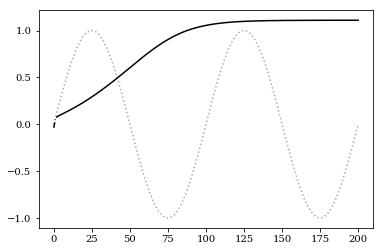

In [10]:
plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

In [11]:
n_batch

<tf.Tensor 'Placeholder_2:0' shape=() dtype=int32>

In [15]:
cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
init_state = cell.zero_state(10, tf.float32)
state=init_state
outputs=[]
x=tf.placeholder(tf.float32, shape=[None, 2, 1])


In [17]:
(cell_output, state) = cell(x[:, 0, :], state)

In [20]:
X.shape

(199, 2, 1)

In [ ]:
with tf.variable_scope('RNN'):
    for t in range(maxlen):
        

In [ ]:
# For simplicty reasons, let us first implement a function that only has 2 lags
U = weight_variable([1, 1])
W = weight_variable([1, ])

h2 = tf.tanh(U)
V = weight_variable([n_hidden, 1])
c = bias_variable(1)
y = tf.matmul(h2, V) + c